this notebook has 2 phases:

* in the first part we define a function that draws the fourrier curven given coefficients

* second part is a neural net aiming at doing the reciprocate

 inspired by https://www.youtube.com/watch?v=-qgreAUpPwM

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
import numpy as np
from operator import itemgetter
import pandas as pd
import cmath
# parameters
FOURRIER_DIM = 100
RESOLUTION_ANGULAR = 1/200.
SIZE = 5

In [2]:
%matplotlib notebook

# Drawing from coefficients


In [3]:
class FourrierCurve(dict):
    def __init__(self, keys, values):
        """
        keys: list of integers frequencies (relative)
        values: list of complex coefficient for each integer frequency
        """
        self.update(zip(keys, values))
        self.trajectory = None

    def __getitem__(self, key):
        """
        default complex coefficient
        """
        return self.get(key, complex(0,0))

    def compute_trajectory(self):
        freqs = list(filter(
            lambda x: x!=0,
            sorted(self.keys(), key=lambda k : np.abs(k) + (0.5*k>0))
        ))

        steps = np.arange(0, 1, RESOLUTION_ANGULAR)

        unitary_rotation = pd.Series(
            data = [cmath.rect(1, 2*np.pi*freq*RESOLUTION_ANGULAR) for freq in freqs],
            index=freqs
        )

        coefs = pd.Series(
            data = [self[freq] for freq in freqs],
            index=freqs
        )

        res = pd.concat([unitary_rotation]*len(steps), axis=1)
        res.columns = steps

        # for a given angle n, the rotation is the sum of n unitary roations
        res = res.cumprod(axis=1)

        # multiply by initial coefficient
        res = res.multiply(coefs, axis=0)
        # total position of the nth arrow
        res = res.cumsum(axis=0)
        # add start
        res = res.add(self[0])
        self.trajectory = res
        return
    

    def normalize_coefs(self):
        if self.trajectory is None:
            self.compute_trajectory()
        # compute bounding box
        max_x, max_y = self.trajectory.iloc[-1, :].apply(complex_to_xy).apply(pd.Series).max()
        min_x, min_y = self.trajectory.iloc[-1, :].apply(complex_to_xy).apply(pd.Series).min()
        limiting_dim = max(max_x-min_x, max_y - min_y) / (2*SIZE)
        
        for idx, value in self.items():
            self[idx] = self[idx] / limiting_dim
        self[0] = complex(0, 0)
            
        self.compute_trajectory()
        return
        
        
        

    def draw(self):
        if self.trajectory is None:
            self.compute_trajectory()
        # draw end
        # last row = position of the end of the arrows
        # separate into imaginary and real part
        coordinates = self.trajectory.iloc[-1, :].apply(complex_to_xy).apply(pd.Series)
        plt.plot(coordinates[0], coordinates[1])
        plt.axis('equal')
        plt.show()

        return

    def animate(self):
        if self.trajectory is None:
            self.compute_trajectory()
        
        # animate
        # animation: https://matplotlib.org/3.2.1/api/animation_api.html
        # animation patch: https://stackoverflow.com/questions/19981054/animating-patch-objects-in-python-matplotlib
        # https://stackoverflow.com/questions/22771111/using-matplotlib-patch-inside-an-animation
        # anim within function: https://stackoverflow.com/questions/21099121/python-matplotlib-unable-to-call-funcanimation-from-inside-a-function/21116525#21116525

        fig, ax = plt.subplots()
        xend, yend = [], []
        xarrows, yarrows = [], []
        ln, = plt.plot([], [], '.')
        arr, = plt.plot([], [])
        cir = []

        store_arr = dict(
            [
                (
                    frame, zip([0,0], complex_to_xy(self[0]), *self.trajectory[frame].apply(complex_to_xy).to_list())
                ) for frame in self.trajectory.columns
            ]
        )


        def _init():
            ax.set_xlim(-SIZE, SIZE)
            ax.set_ylim(-SIZE, SIZE)
            for f in [0] + list(self.trajectory.index):
                cir.append(ax.add_patch(mpl.patches.Circle((0,0), radius=abs(self[f]), fill=False, alpha=0.2)))
            return [ln, arr]+ cir

        def _update(frame):
            x, y = store_arr[frame]
            xend.append(x[-1])
            yend.append(y[-1])
            ln.set_data(xend, yend)
            arr.set_data(x, y)
            for idx, c in enumerate(cir):
                c.set_center((x[idx], y[idx]))
            return [ln, arr]+ cir

        ani = FuncAnimation(fig, _update, frames=self.trajectory.columns,
                            init_func=_init, blit=True)
        plt.axis('equal')
        plt.show()
        return ani
        
def complex_to_xy(x): return (x.imag, x.real)


In [4]:
test = FourrierCurve([0, 1, -1, 3], [complex(0,0), complex(1,0), complex(0.5,0.5), complex(1,0)])
test2 = FourrierCurve([0, 1, -1, 3, -3], [complex(1,0), complex(1,0), complex(0.5,0.5), complex(1,0), complex(0.2, 0.2)])

<IPython.core.display.Javascript object>


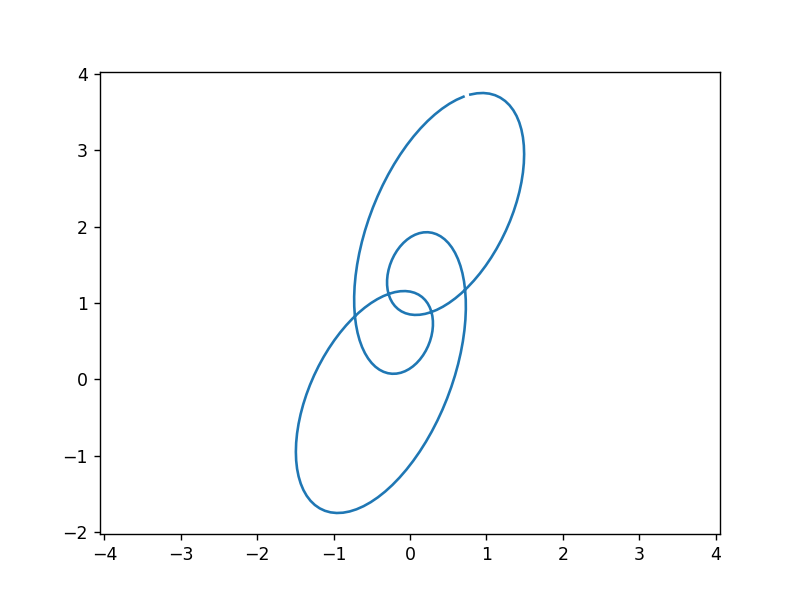

In [5]:
test2.draw()

<IPython.core.display.Javascript object>


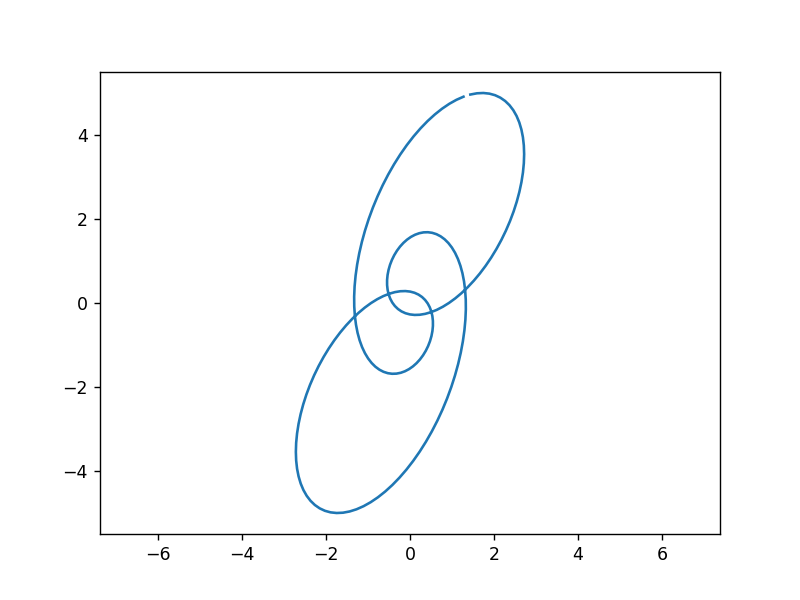

In [6]:
test2.normalize_coefs()
test2.draw()

<IPython.core.display.Javascript object>


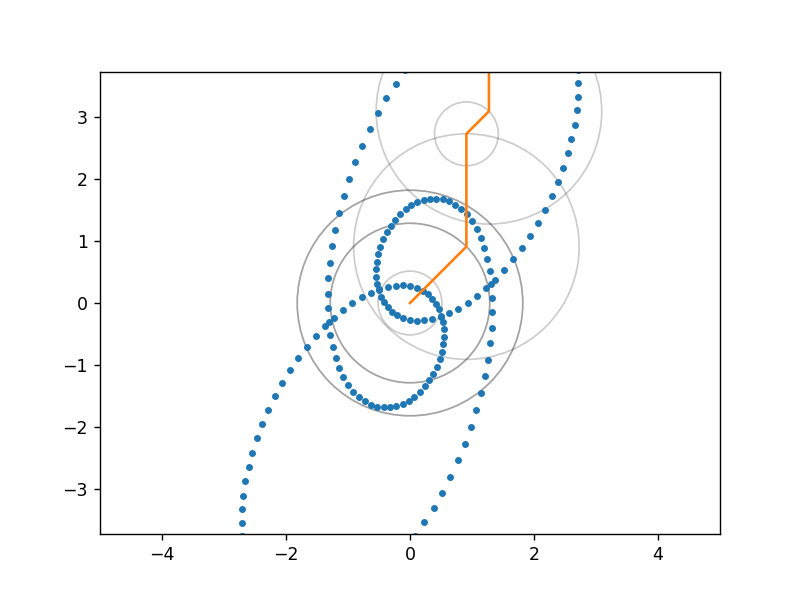

In [7]:
a = test2.animate()

## reverse

In [8]:
FUNC_DISC_STEP = 200

In [58]:
class polygon:
    def __init__(self, bp):
        """
        bp: pd.DataFrame colonnes x, y
        """
        self.liste_bp = bp
        # close the loop if needed
        if (self.liste_bp.iloc[0,:] != self.liste_bp.iloc[-1,:]).any():
            self.liste_bp = self.liste_bp.append(
                self.liste_bp.iloc[0,:], ignore_index=True
            )
        
        
        dist_to_next = np.sqrt(np.square(self.liste_bp - self.liste_bp.shift(1)).fillna(0).sum(axis=1))
        distance_along_line = dist_to_next.cumsum()
        total_length = distance_along_line.max()
        distance_along_line = distance_along_line / total_length
        
        self.step = 1./FUNC_DISC_STEP
        self.steps = np.arange(0, 1, self.step)
        
        self.well_sampled_bp = pd.DataFrame(index = self.steps)
        self.well_sampled_bp['x'] = np.interp(
            # compute FUNC_DISC_STEP point along the line
            self.steps,
            # position along the line for initial data
            distance_along_line.values,
            # value of x on this line
            self.liste_bp['x']
        )/ total_length
        self.well_sampled_bp['y'] = np.interp(
            # compute FUNC_DISC_STEP point along the line
            self.steps,
            # position along the line for initial data
            distance_along_line.values,
            # value of x on this line
            self.liste_bp['y']
        )/ total_length
        
        self.complex_values = pd.Series(
            self.well_sampled_bp['x'] + 1j* self.well_sampled_bp['y'],
            index = self.steps
        )
        
        self.unitary_rotation = pd.Series(
            index = self.steps,
            data = np.exp([2j* np.pi * idx for idx in self.steps])
        )
        
    def draw(self, which='well_sampled'):
        data = self.liste_bp if (which == 'original') else self.well_sampled_bp
        plt.plot(data['x'], data['y'])
        plt.scatter(data['x'], data['y'], s=2)
        plt.axis('equal')
        plt.show()

        
    def compute_coef(self, freq):
        return self.complex_values.multiply(np.power(self.unitary_rotation, -freq)).sum(axis=0) * self.step 
    
    def convert_to_fourrier(self, number_fourrier_dim=FOURRIER_DIM):
        coefs = {}
        for freq in np.arange(-number_fourrier_dim, number_fourrier_dim):
            coefs[freq] = self.compute_coef(freq)
        reproduction = FourrierCurve(
            coefs.keys(),
            coefs.values()
        )
        # rotated for some reason ..
        reproduction.normalize_coefs()
        return reproduction
        
    

In [59]:
# a = pd.DataFrame(index=range(9))
# a['x'] = [4,3,2,1,0,1,2,3,4]
# a['y'] = [0,1,2,1,0,1,2,1,2]

x = np.cos([t for t in np.arange(0, 2*np.pi, 0.01)]) + 0.5*np.cos([3*t for t in np.arange(0, 2*np.pi, 0.01)])
y = np.sin([t for t in np.arange(0, 2*np.pi, 0.01)])+ 1.5*np.sin([-3*t for t in np.arange(0, 2*np.pi, 0.01)])
a = pd.DataFrame(index = np.arange(0, 2*np.pi, 0.01))
a['x'] = x
a['y'] = y

test = polygon(a)

<IPython.core.display.Javascript object>


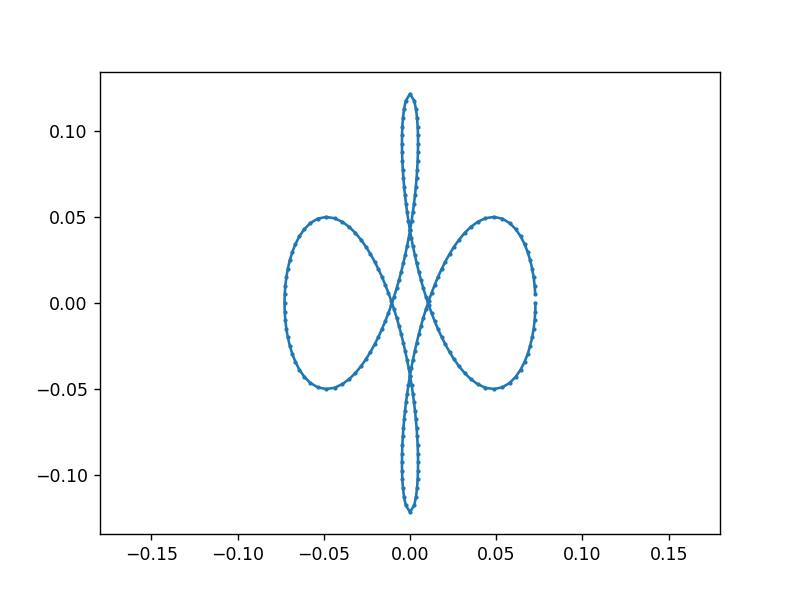

In [60]:
test.draw()

<IPython.core.display.Javascript object>


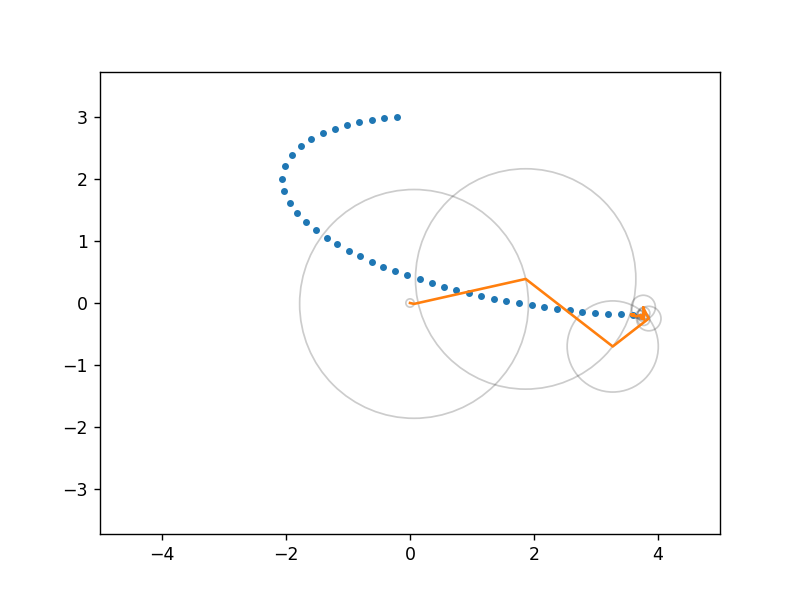

In [61]:
reproduction = test.convert_to_fourrier()
reproduction.animate()

## custom drawing

<IPython.core.display.Javascript object>


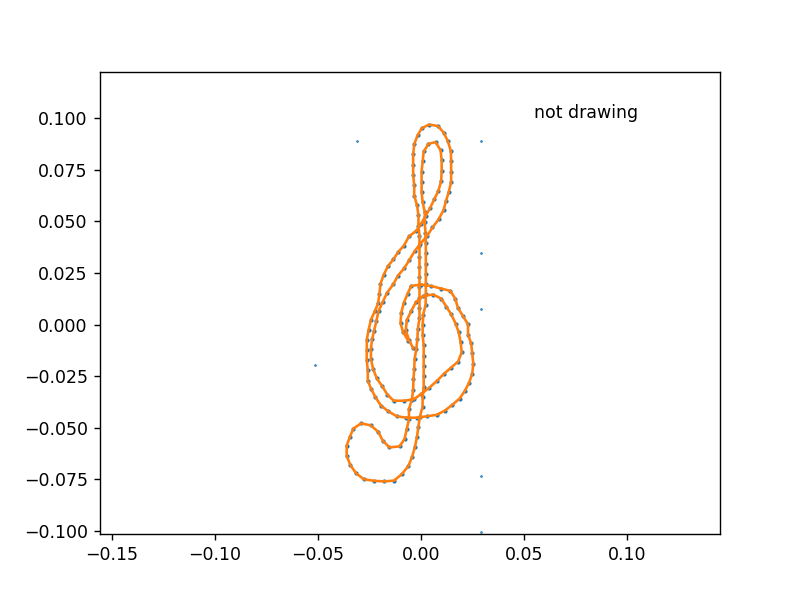

In [68]:
# https://matplotlib.org/3.1.0/gallery/misc/cursor_demo_sgskip.html

class Cursor(object):
    def __init__(self, ax):
        self.ax = ax
        self.is_drawing = False
        self.x = []
        self.y = []
        self.plot, = plt.plot([], [], '.', markersize=1)
        self.txt = ax.text(0.7, 0.9, '', transform=ax.transAxes)

    def mouse_move(self, event):
        if not event.inaxes:
            return
        
        if self.is_drawing:
            self.x.append(event.xdata)
            self.y.append(event.ydata)
            self.plot.set_data(self.x, self.y)
            self.ax.figure.canvas.draw()
        
            
    def mouse_click(self, event):
        self.is_drawing = not self.is_drawing
        self.txt.set_text('not' * (not self.is_drawing) + ' drawing')
        
    def export_drawing(self):
        res = pd.DataFrame(index = range(len(self.x)))
        res['x'] = self.x
        res['y'] = self.y
        return res
        

fig, ax = plt.subplots()
ax.set_xlim(-SIZE, SIZE)
ax.set_ylim(-SIZE, SIZE)
cursor = Cursor(ax)
fig.canvas.mpl_connect('button_press_event', cursor.mouse_click)
fig.canvas.mpl_connect('motion_notify_event', cursor.mouse_move)

plt.show()

In [69]:
# put it in Polygon object
test = polygon(cursor.export_drawing())
test.draw()

<IPython.core.display.Javascript object>


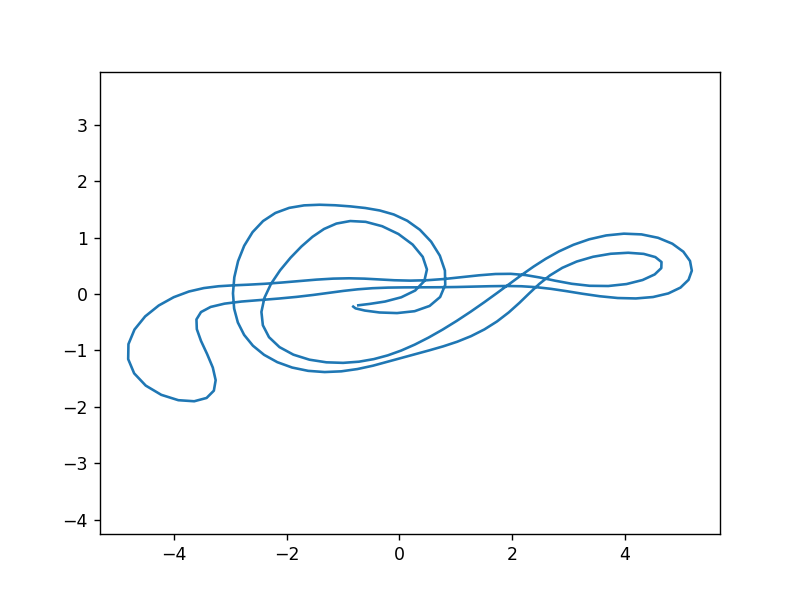

In [72]:
reproduction = test.convert_to_fourrier(20)
reproduction.draw()